#1. Validação cruzada e aleatoriedade inicial

O que será visto:

- Importar arquivo .py para o google colab

- Utilizar o método read_csv do pandas

- O que é a validação cruzada(cross validation)

- Utilizar o std para saber o desvio padrão

- Árvore de classificação

##Introdução

Trataremos da validação dos nossos estimadores, isto é, o quão bem estão se saindo? São bons ou não?

Vimos a técnica de **hold out**, que consistem em separar a base em treino e teste. Mas ela apresenta certos problemas e há alternativas, baseadas na técnica de **validação cruzada**, para entender melhor como nosso estimador (modelo) funcionará no mundo real.

Então veremos:

- a motivação para validação cruzada;

- a importância da aleatoriedade, mesmo na validação cruzada;

- simularemos situação de azar, em que algo ruim pode acontecer e nosso algoritmo se sair muito ruim se não usarmos validação cruzada ou estratificação, ou ambos juntos;

- dados que possuem características que deixam que eles não sejam independentes entre si, ou seja, a leitura das nossas informações possuem certa dependência e, podemos então, agrupá-las. Ex.: Modelos dos carros. Quero saber como o algoritmo se comporta com carros que não conhece. Temos aí uma característica de grupo, e veremos como fazer validação cruzada com grupos;

- como colocar a validação cruzada num processo, pois algum dos nossos estimadores possuem mais de uma fase, para que possamos ter uma melhor qualidade, para que nossa medida de sucesso (métrica) seja maximizada, vamos querer alguns passos anteriores (ex.: StandardScaler). Então vamos colocar isso num processo para ser executado junto à validação cruzada. 

##A influência da aleatoriedade na validação do modelo

Carregando os dados

In [1]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1) #desconsidera/apaga a coluna "0", que está sem nome e não interessa
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


A ideia é criar um modelo para classificar se o vendido será vendido ou não, com base nas features preço, idade_do_modelo e km_por_ano.

Vendido:

1 - Sim

0 - Não

Separando os dados

In [2]:
#Carregando bibliotecas
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

#Separando features e labels
x = dados[["preco", "idade_do_modelo", "km_por_ano"]]
y = dados["vendido"]

#Separando treino e teste
SEED = 158020
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25, stratify=y)

print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

Treinaremos com 7500 elementos e testaremos com 2500 elementos


Definindo o baseline da taxa de acerto

Antes de rodar o modelo, precisamos decidir o que é uma taxa de acerta aceitável, boa ou ruim.

Maneiras possíveis:

- Perguntar a um expert humano se determinado carro será ou não vendido, e ver a taxa de acerto dele;

- Melhor que um expert, seria perguntar a vários experts. E aí tirar uma média ou considerar a moda, etc;

Como não temos esses experts para termos uma base, vamos olhar para a base de dados e, se 70% dos carros foram vendidos e 30% não, vou chutar que 70% vai vender e 30% não vai. Seria como chutar com base na experiência, ou seja, com base na proporção dos dados que temos.

Esse é o processo do DummyClassifier. E por padrão, ele é estratificado. Vamos ver a taxa de acerto:

In [3]:
from sklearn.dummy import DummyClassifier

dummy_stratified = DummyClassifier()
dummy_stratified.fit(treino_x, treino_y)
acuracia = dummy_stratified.score(teste_x, teste_y) * 100

print("A acurácia do dummy stratified foi %.2f%%" % acuracia)

A acurácia do dummy stratified foi 58.00%


Até acreditamos que um expert humano acerte mais que os 58%. Mas não temos experts, portanto vamos usar esse valor como baseline.

Treinar o modelo e colher a taxa de acerto

In [4]:
from sklearn.tree import DecisionTreeClassifier

SEED = 158020
np.random.seed(SEED)
modelo = DecisionTreeClassifier(max_depth=2) #profundidade máxima da árvore = 2
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

A acurácia foi 71.92%


Acurácia de 71,92%. Mas digamos que alguém diga: "Mas os experts são capazes de acertar mais, certa de 73%. Então melhor não usarmos esse algoritmo."

Mas calma: Veja que no código usamos o SEED, um número aleatório qualquer para que pudéssemos rodar várias vezes e obtermos o mesmo resultado.

E se o valor do SEED fosse outro? Vamos verificar:



In [5]:
#Separando features e labels
x = dados[["preco", "idade_do_modelo", "km_por_ano"]]
y = dados["vendido"]

#Separando treino e teste
SEED = 5
np.random.seed(SEED)
treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, test_size = 0.25, stratify=y)

print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(treino_x), len(teste_x)))

#Treinamento do modelo e acurácia
modelo = DecisionTreeClassifier(max_depth=2) #profundidade máxima da árvore = 2
modelo.fit(treino_x, treino_y)
previsoes = modelo.predict(teste_x)

acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)



Treinaremos com 7500 elementos e testaremos com 2500 elementos
A acurácia foi 76.84%


Com 76,84%, agora estou melhor que o expert que acerta 73%. E aí, a minha decisão então seria: SIM, está melhor que o expert e vamos usar na empresa.

Repare que tem algo errado ocorrendo: minha decisão de usar ou não, de julgar o modelo muito bom (ainda que esteja melhor que o DummyClassifier) ou ruim, iria depender do nº que tivéssemos chutado para o SEED.

Veja que a nossa decisão não deveria depender de uma aleatoriedade. É difícil validarmos o modelo por causa de uma aleatoriedade. Não faz sentido validar ou não o modelo com base em um nº aleatório.

Então, queremos minimizar o efeito dessa aleatoriedade, dessa escolha aleatória do treino e do teste, bem como da árvore de decisão, na nossa decisão.

E calma lá: Se eu rodo o treino e o teste 1 (uma) única vez, corro o risco de ter separado treino e teste de uma maneira não muito boa. Então, rodar treino e teste de única vez traz risco. Precisamos de uma outra ideia sobre como treinar e testar mais de uma vez, para que não tenhamos uma estimativa única.

Precisamos, então, rodar treinos e testes diversas vezes para obter uma estimativa, do tipo: o acerto está entre 70% e 78%. Então, em vez 1(um) ponto de acerto, no qual estou correndo muito risco, é preferível um intervalo, de modo que eu possa confiar que o acerto está lá dentro.

Portanto, veremos uma solução para que eu possa rodar o treino e teste diversas vezes, e obter um intervalo de taxa de acerto.

##A validação cruzada

A imagem abaixo ilustra o quanto pode ser arriscado trabalhar apenas com estratégia de divisão de treino e teste (hold out), pois fico suscetível ao nº aleatório (que define o que vou escolher para treino e teste) ou à ordem original da minha sequência (se eu não fizer um shuffle):

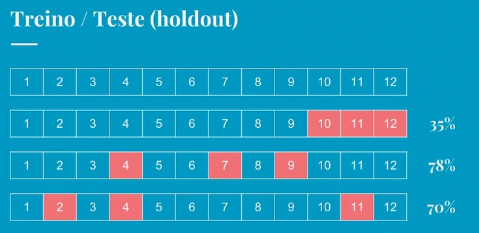

Outro exemplo do dia a dia é quando vou fazer uma prova. Imagine que no dia anterior tive um problema (briga) que me desconcentrou, e aí tiro apenas 3,5. Logo, esse fator externo atrapalhou.

Mas fazemos várias provas ao longo do ano. E na 2ª e 3ª tenho desempenhos melhores que o da 1ª.

Note então que quando eu testo um aluno várias vezes, começa a tirar ou tentar diminuir a influência de alguns fatores externos (no caso da prova, fatores como  a briga. Para um algoritmo, o efeito do shuffle ou outros problemas).

E quando rodo o teste várias vezes, posso tirar uma média.

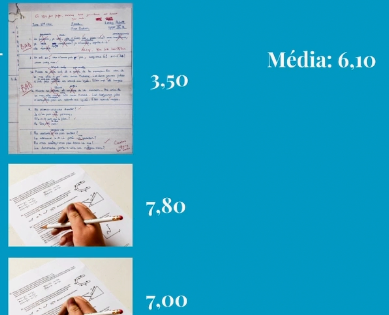

Então, e com base na 1ª ilustração, podemos pegar nossos 12 elementos e dividi-los em 2. Treinar com os 6 primeiros e testar com os 6 últimos. E aí digamos que o 1º resultado foi de 55%.

Depois treinar com os 6 últimos e testar com os 6 primeiros. E o resultado foi 78%.

Daí podemos tirar a média dos resultados, e obter 66,55:

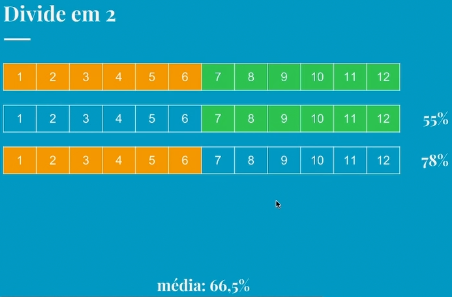




Dessa maneira, começamos a diminuir a influência da aleatoriedade das posições ou da pre-determinação das posições no resultado.

Então, em vez de apenas fazer o *hold out*, separamos em 'n' pedaços, treinamos e testamos de maneira meio que cruzada. E aí validamos nosso algoritmo de maneira cruzada. O nome é **cross validation**. E há diversas maneiras de fazê-la:

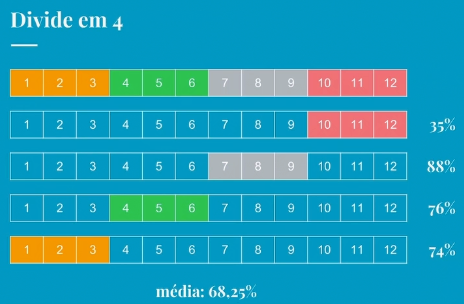

O importante é a ideia: Quebrar em 'n' pedaços ('k' pedaços) e rodar 'k' processos de treino e teste, validando de uma maneira cruzada o nosso algoritmo/estimador:

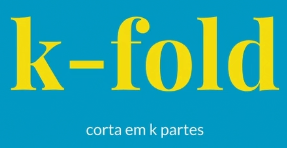

Veja o exemplo com a divisão em 8 pedaços. Terei então 8 resultados e posso tirar a média.

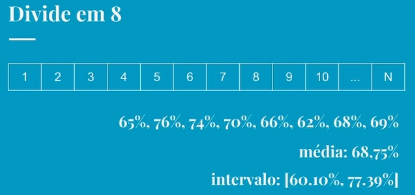

Só que a média visa obter um valor, um ponto certeiro, que é uma medida complicada, de difícil utilização 'secamente'/pontualmente.

O que vamos querer usar é um intevalo que me dê uma confiança em que eu acredito que o nº esperado (o quão bem o algoritmo é, ou funcionará no mundo real) estará lá dentro.

Então, quando temos um conjunto de números como esses, podemos usar a média e o desvio padrão, se acreditarmos que essa distribuição é normal.

Imagine que eu tenha 12 elementos e decida dividir 12 pedaços (k = 12). Significa que treinarei 12 vezes... Caso queira fazer isso com uma base de 100 mil elementos, serão 100 mil treinamentos, e isso vai demorar demais, embora dê uma estimativa mais realista do que esperar no mundo real.

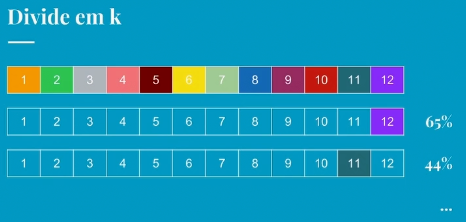


Portanto, escolher o 'k' é um detalhe importante.

E quando escolhemos a estratégia de escolher o 'k' exatamente igual ao nº de elementos que temos, ou seja, deixar exatamente 1(um) elemento de fora do treino, é chamado de 'leave one out', ou deixar um de fora.

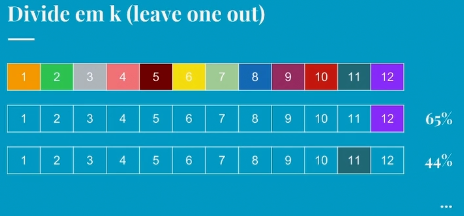


##Usando e avaliando com o cross validate

Vimos então a importância de rodar mais de um conjunto de treino e teste, de modo a obtermos um intervalo: "Acreditamos que a taxa de acerto esteja mais ou menos na faixa de x%."

Vamos ver como implementar com o sklearn:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

Será usado para validar um modelo, isto é, definir se o modelo será aplicável ou para comparar 2 modelos. A ideia é validar/selecionar um modelo dentre diversos.

In [6]:
from sklearn.model_selection import cross_validate

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x, y, cv = 3) #Não passa x e y quebrados! A validação cruzada fará isso.
results

{'fit_time': array([0.01026225, 0.01044703, 0.01161361]),
 'score_time': array([0.00390959, 0.00339365, 0.00348616]),
 'test_score': array([0.75704859, 0.7629763 , 0.75337534])}

Retornou um dicionário com **tempo de treino**, **tempo para dar a nota** e o **resultado do teste**. Então vamos pegar apenas o resultado do teste:

In [7]:
results['test_score']

array([0.75704859, 0.7629763 , 0.75337534])

Temos 3 resultados pois separou e rodou treino e teste 3 vezes (cv = 3).

Lembra de sempre rodar com um SEED fixo. Então vamos rodar novamente com o SEED fixo, para mantermos a reprodutibilidade do nosso código.

In [8]:
from sklearn.model_selection import cross_validate

SEED = 158020
np.random.seed(SEED)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x, y, cv = 3) #Não passa x e y quebrados! A validação cruzada fará isso.
results['test_score']

array([0.75704859, 0.7629763 , 0.75337534])

Dados esses 3 valores de resultado, quero saber a média:

In [9]:
results['test_score'].mean()

0.7578000751484867

Mas não queremos apenas a média. Queremos um intervalo. E se lembrarmos do conceito (Curso de Estatística Alura), temos que 95% da densidade estará dentro da média + ou - 2 desvios padrões.

Então, a (média - 2 x desvio padrão) + (média + 2 x desvio padrão) formarão para nós um intervalo que queremos imprimir:


In [10]:
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 3 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 3 = [74.99, 76.57]


Portanto, o intervalo de resultados da taxa de acerto (acurácia) ficou entre 74,99% e 76,57%.

Vamos então compilar todo o código e alterar o SEED para 5, para ver o efeito nas taxas de acerto:

In [11]:
from sklearn.model_selection import cross_validate

SEED = 5
np.random.seed(SEED)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x, y, cv = 3) #Não passa x e y quebrados! A validação cruzada fará isso.
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 3 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 3 = [74.99, 76.57]


Note que o intervalo dos resultados ainda é de 74,99% a 76,57%.

Vamos trocar o SEED novamente, agora para 301:

In [12]:
from sklearn.model_selection import cross_validate

SEED = 301
np.random.seed(SEED)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x, y, cv = 3) #Não passa x e y quebrados! A validação cruzada fará isso.
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 3 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 3 = [74.99, 76.57]


O intervalo da acurácia permanece igual!

Estamos mudando o nº aleatório que influencia o nosso algoritmo, mas, só pelo fato de eu fazer 3 vezes o processo de treino e teste, o resultado não mudou.

Então não estou mais tão suscestível a esse aleatoriedade (SEED) para escolher o modelo. Porém, ainda estamos suscetível ao CV. Porque escolhemos 3? E se fosse 10?

In [13]:
#Com CV = 10
SEED = 301
np.random.seed(SEED)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x, y, cv = 10) #Não passa x e y quebrados! A validação cruzada fará isso.
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 3 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 3 = [74.24, 77.32]


O intervalo mudou!

Vamos tentar com CV = 5:

In [14]:
#Com CV = 5
SEED = 301
np.random.seed(SEED)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x, y, cv = 5) #Não passa x e y quebrados! A validação cruzada fará isso.
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 3 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 3 = [75.21, 76.35]


O intervalo mudou novamente!

Então, **qual número usar para o CV (Cross Validation)?**

Existem papers científicos que tentam mostrar e, na documentação do sklearn, há referência a alguns deles, que uma **escolha entre 5 ou 10 já é o suficiente**!

Então, vamos manter CV = 5 como resultado para o nosso cliente. Inclusive, na documentação do sklearn 5 é o padrão para o CV.



In [15]:
#Com CV = 5
SEED = 301
np.random.seed(SEED)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x, y, cv = 5) #Não passa x e y quebrados! A validação cruzada fará isso.
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 3 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 3 = [75.21, 76.35]


Portanto, CV = 5 é o nº que costumamos começar quando fazemos o cross validate.

Então, resolvemos o problema de estarmos suscetiveis a um nº aleatório. E agora existe um nº que define quantas vezes vamos rodar o processo de treino e teste (CV), e que definirá nosso intervalo de média e desvio padrão que passaremos aos nossos clientes. Mas já está muito melhor que antes!

#2. KFold e aleatoriedade

O que será visto:

- Utilizar o método KFold para embaralhar(shuffle)

##Kfold com aleatorização

Por mais que nosso algoritmo esteja funcionando, vamos dar uma revisada:

Estamos usando o DecisionTreeClassifier e o cross_validate. Mas o cross_validate em si não recebe aquele parâmetro de aleatoriedade:

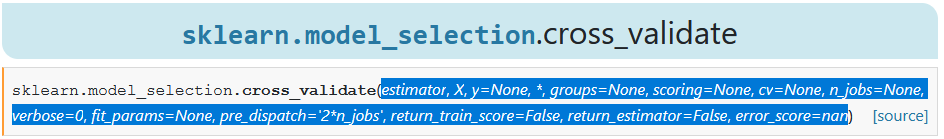

A razão é que, por padrão, o cross_validate não tem aleatoriedade. Da maneira como estamos utilizando, ele quebra em 'k' pedaços, ou seja, é determinístico, de modo que sabemos em quantos pedaços quebrar.

Então, a aleatoriedade que setamos com o SEED só está entrando no DecisionTreeClassifier e, para ser bem sincero, esse algoritmo só vai usar aleatoriedade, por padrão, num caso bem específico, que vai ocorrer muito pouco. Assim, ainda que mudemos bastante o SEED, teremos basicamente os mesmos números.

Então, o que eu queria era rodar de maneira aleatória, de verdade. Por mais que eu receba meus dados numa sequência, não quero quebrá-los em 5 pedaços e fazer o cross_validate.

Quero então primeiro embaralhar e, depois, fazer o cross_validate. Vamos ver:

**Aleatoriedade no cross validate**

O cross_validate não possui o parâmetro para embaralharmos os números. Contudo, o CV aceita como parâmetro tanto um número quanto um gerador de validação cruzada:

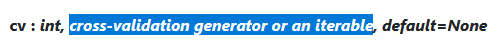

E aí existem diversos geradores de validação cruzada. O que estamos usando é aquele que corta, dobra, 'folda' nossos dados em 'k' vezes. E o sklear tem o KFold no model_selection.

Então, esse KFold é o que estamos usando por trás dos panos. Então, o nosso cross_validate é um KFold de 'n_splits':

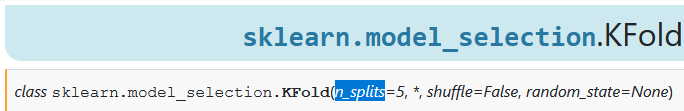

Então, podemos representar:

In [16]:
#CV = 10. E gostaria que ele embaralhasse.
from sklearn.model_selection import KFold

SEED = 301
np.random.seed(SEED)

cv = KFold(n_splits = 10) #Estabelecendo o cross_validate generator
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x, y, cv = cv) #Usando o cv generator
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [74.37, 77.19]


Para facilitar, vamos jogar os valores de média, desvio padrão em uma função.

In [17]:
def imprime_resultados(results):
  media = results['test_score'].mean()
  desvio_padrao = results['test_score'].std()
  print("Accuracy médio %.2f" % (media * 100))
  print("Accuracy intervalo = [%.2f, %.2f]" % ((media - 2 * desvio_padrao) * 100, (media + 2 * desvio_padrao) * 100))

Agora vamos treinar usando a função:

In [18]:
from sklearn.model_selection import KFold

SEED = 301
np.random.seed(SEED)

cv = KFold(n_splits = 10) #Estabelecendo o cross_validate generator
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x, y, cv = cv) #Usando o cv generator
imprime_resultados(results)

Accuracy médio 75.78
Accuracy intervalo = [74.37, 77.19]


Mas como dito, queremos fazer algo a mais do que só quebrar em 10 pedaços. 

O objeto KFold criado, ele sim permite um **shuffle** e tem o **random_state** para ser setado:

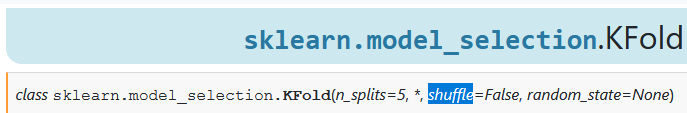

Vamos então rodar com o shuffle:



In [19]:
SEED = 301
np.random.seed(SEED)

#Estabelecendo o cross_validate generator com shuffle: "Olha, bagunça aí primeiro!".
#Definindo o n_splits como 10 e o shuffle estamos pegando 10 elementos e embaralhando-os.
cv = KFold(n_splits = 10, shuffle = True) 
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x, y, cv = cv) #Usando o cv generator
imprime_resultados(results)

Accuracy médio 75.76
Accuracy intervalo = [73.26, 78.26]


E 'bagunçando' os números com shuffle, vimos que os resultados são outros. Claro, se rodar de novo será determinístico e, repare que a média ficou muito próxima, mas o intervalo é outro.

Na prática, se meus dados não possuem alguma 'estrutura interna' como uma sequencia por datas ou algo do gênero, vou, em geral, gerar uma forma aleatória desses dados e aí quebrar em 10 pedaços, ou fazer as 2 coisas ao mesmo tempo. 

Essa é a forma tradicional que iremos executar: com o shuffle e com o split.

Dessa forma, podemos usar não apenas o KFold, mas diversos outros quebradores de grupos, que são os '**Splitter Classes**':

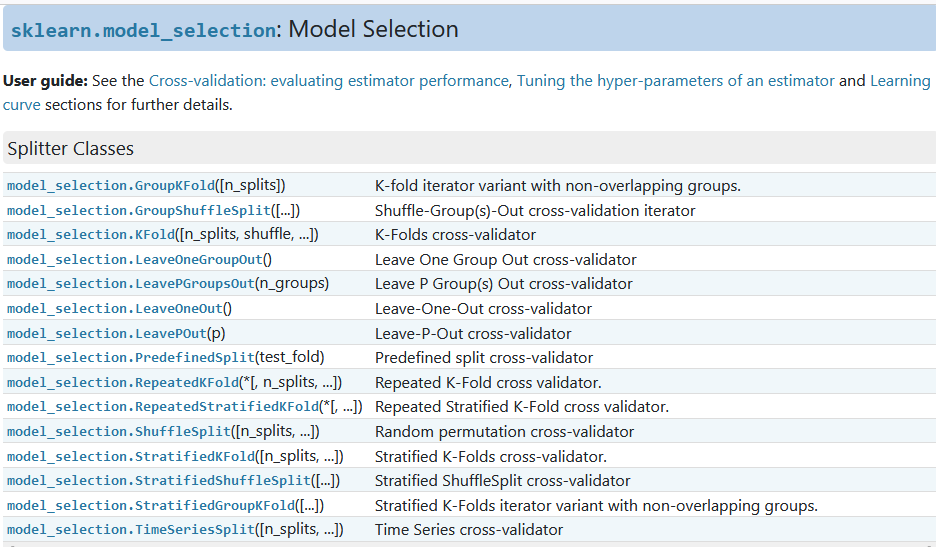



#3. Estratificação

O que será visto:

- Simular uma situação com dados

- Ordenar nosso dataframe utilizando o sort_value(“vendido“’)

##Estratificação com validação cruzada

Vamos para o próximo desafio. Vimos que o feito anteriormente está funcionando mas, sempre posso dar muito azar numa condição muito específica.

E antes de trabalharmos com validação cruzada, já vimos uma questão de sorte/azar, em que a validação era simples, do tipo treino/teste (holdout).

A gente dava o azar de que os nosso dados (pré ou pós shuffle) fossem separados com uma classe, por exemplo, '0 - não vendido' com quase todo mundo no treino e com a classe '1 - vendido' praticamente toda no teste.

Isto é: tenho um desbalanceamento das classes, seja no conjunto inteiro de dados ou na hora de treinar e testar... o importante é que, na hora que vou precisar dos dados, rolou o desbalanceamento, seja pela aleatoriedade, seja peça natureza dos dados.

Então, se eu cair nesse azar, o que pode ocorrer?

Já vimos que na separação train_test_split (também no model.selection), temos um parâmetro 'stratify', que define: "Olha, coloca proporcional: Se há 70% na classe 0 e 30% na parte 1, coloca também a proporçãodas classes 70/30 tanto na parte de treino quanto na de teste.

Mas agora, no cross_validate do KFold não há esse parâmetro. KFold tem apenas 2 parâmetros:

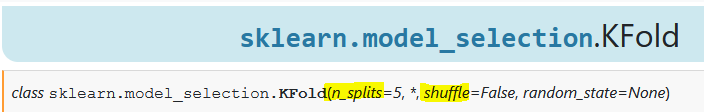

Portanto, usando-o puro não está estratificando. Vamos simular essa situação 'horrível' de azar acontecendo, e aí melhorar o nosso processo adiante:


**Simular situação horrível de azar (sem estratificação)**

Pode ser 'azar' como pode ser um desbalanceamento de classes

In [20]:
#Vamos pegar o dataframe e ordenar pelo vendido, de modo crescente
#Ou seja: Primeiro listará as classes 0, depois a classe 1.

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo", "km_por_ano"]]
y_azar = dados_azar["vendido"]

Separado treino e teste, vamos rodar inicialmente sem o shuflle:

In [21]:
SEED = 301
np.random.seed(SEED)

cv = KFold(n_splits = 10) #Estabelecendo o cross_validate generator
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv) #Usando o cv generator
imprime_resultados(results)

Accuracy médio 57.84
Accuracy intervalo = [34.29, 81.39]


Veja o resultado desastroso!

Vamos agora ver com o shuffle:

In [22]:
SEED = 301
np.random.seed(SEED)

#Estabelecendo o cross_validate generator com shuffle: "Olha, bagunça aí primeiro!".
#Definindo o n_splits como 10 e o shuffle estamos pegando 10 elementos e embaralhando-os.
cv = KFold(n_splits = 10, shuffle = True) 
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv) #Usando o cv generator
imprime_resultados(results)

Accuracy médio 75.78
Accuracy intervalo = [72.30, 79.26]


Veja que o shuffle é bom o suficiente nessa situação em que temos o desbalanceamento.

E se quisermos fazer a estratificação?

Como falado, além do KFold, temos outros separadores de grupo, entre eles o '**StratifiedKFold**', que recebe o n_splits, o shuffle e o random_state:

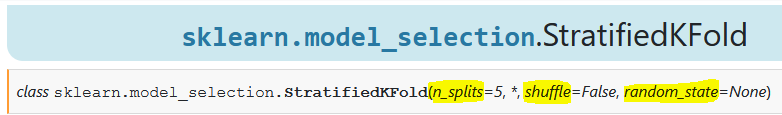

**E o que o StratifiedKFold faz?**

Separa os grupos mantendo a proporção entre as classes:

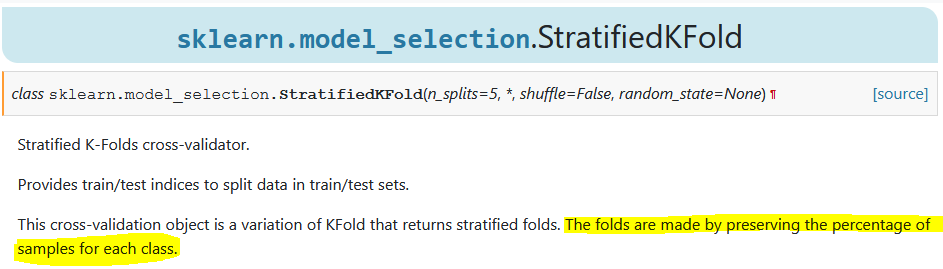

Vamos então implementá-lo:


In [23]:
from sklearn.model_selection import StratifiedKFold

SEED = 301
np.random.seed(SEED)

#Estabelecendo o cross_validate generator com shuffle: "Olha, bagunça aí primeiro!".
#Definindo o n_splits como 10 e o shuffle estamos pegando 10 elementos e embaralhando-os.
cv = StratifiedKFold(n_splits = 10, shuffle = True) 
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv) #Usando o cv generator
imprime_resultados(results)

Accuracy médio 75.78
Accuracy intervalo = [73.55, 78.01]


Veja que o intervalo ficou um pouco mais fechado em relação ao anterior (sem o StratifiedKFold). Mas quem eu usaria.

Portanto, principalmente quando temos o desbalanceamento entre as classes, é interessante usar o StratifiedKFold.

##Documentação e boas práticas

Como dito, há diversas maneiras para validar nossos estimadores, como essa árvore de decisão que estamos criando.

Poderíamos usar validação tradicional com treino/teste (hold-out) com validação cruzada. E a validação cruzada ou o treino/teste podem usar valores aleatórios para 'bagunçar' nossos dados antes.

Também podemos fazer isso de forma estratificada, ou misturar tudo isso: misturar estratificado com aleatório com validação cruzada.

E voltando ao 'Splitter Classes', vemos diversas classes e, cada uma, com um momento onde é recomendável ser utilizada:

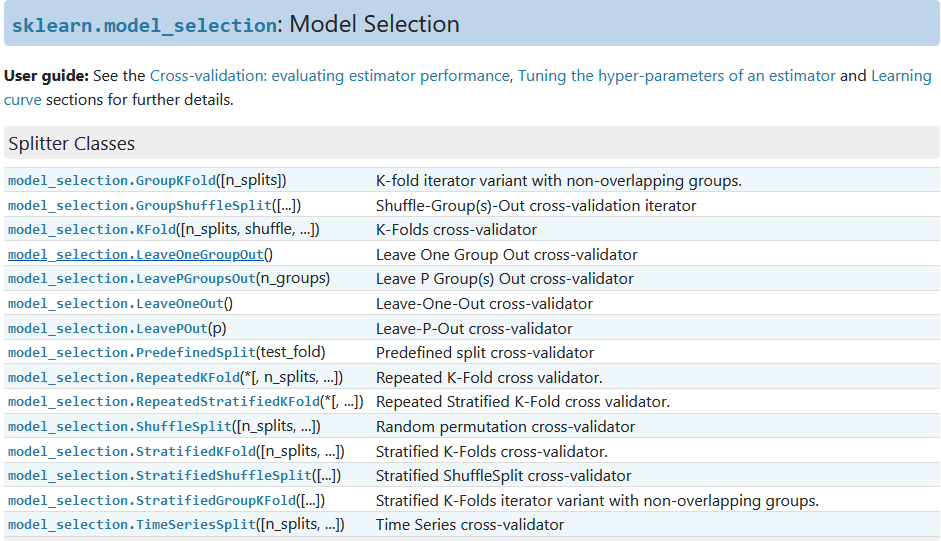

Existem papers e há muita literatura na ciência dizendo quando utilizar um ou outro, desvantagens, etc. Mostramos aqui alguns usos para termos uma previsão bem realista sobre o quão bem esse algoritmo vai rodar em produção.

Na própria documentação do sklearn podem ser encontradas boas práticas. Ler a documentação das próprias classes, etc. Há diversos guias sobre quando usar um ou outro. Recorra à documentação e até mesmo a links externos citados na documentação.

Na sequencia trataremos de outras abordagens para validarmos nosso modelo, seja para validar o quão bem ele funciona ou comparar modelos.

#4. Dados agrupáveis

O que será visto:

- Gerar dados aleatórios com o randint

- Gerar uma nova coluna de dados

- Utilizar o comando unique para mostrar os modelos únicos

- Utilizar o GroupKFold para agrupar por grupo

Este posts dão uma explicação legal do funcionamento do GroupKFold:

https://cursos.alura.com.br/forum/topico-sobre-o-groupkfold-178753

https://cursos.alura.com.br/forum/topico-funcionamento-do-groupkfold-140617

##Gerando dados aleatórios

Até aqui vimos diversas maneiras de quebrar nossos dados para fazer a validação cruzada (cross_validate). Basicamente, vimos:

- KFold

- StratifiedKFold

E com ou sem aleatoriedade.

Tinhamos visto antes o train_test_split.

Mas vamos parar pra pensar: As vezes meus dados tem características especiais. Exemplo: No caso de um hospital, as vezes tenho um paciente que lá entrou e tenho diversas informações sobre ele, ou seja, tenho várias linhas de dados sobre ele. Assim como várias linhas sobre diversos outros pacientes.

Preciso tomar cuidado com o seguinte: Quando eu separo o treino e o teste, preciso pensar: Quando treino meu algoritmo, treino com os dados. Quando testo, tenho que ser capaz de testar como se fosse no mundo real.

E pare pra pensar: No mundo real do hospital, quando tenho que testar algo, tenho um  paciente novo, isto é, quando Thiago entra no hospital, ele é um paciente novo, nunca foi visto no hospital. E aquilo que havia sido treinado com outros pacientes, tem que funcionar no paciente novo.

Então, o algoritmo que foi treinado em diversos outros pacientes tem que funcionar com o Thiago, que é um paciente novo. 

Assim, repare que na hora de separar treino e teste, teríamos que agrupar pelos pacientes. Não poderia colocar dados do Thiago no treino e no teste, pois no mundo real do hospital, o paciente é uma pessoa nova. Queremos ser capaz de trabalhar com pacientes novos. E se sempre, no meu treino, e no meu teste, tenho repetição dos pacientes, meu algoritmo é capaz de não generalizar bem para novos pacientes. 

A mesma coisa vale para os carros: Se tenho diversos carros para os quais meu algoritmo funcionou bem no passado, quando surgir um carro novo, um novo modelo, será que o algoritmo será capaz de funcionar para esse modelo novo de carro?

Não sei! Pois do jeito que estou fazendo, estou treinando todos os carros. No treino tenho todos os modelos de carro, assim como também no teste. Mas não tenho dados agrupados por modelos de carros, por paciente, não agrupado pela característica que define um novo tipo de dado que entrará no futuro, quando tiver que estimar no mundo real.

Então, vou pegar essa característica que é um agrupamento e tentar trabalhar nos nossos dados, isto é, no caso dos carros, para mim é o modelo do carro. Por exemplo, até hoje não existe um modelo chamado 'Super Thiago', mas quando tal modelo passar a existir, tenho que ser capaz de prever para ele também.

E como faremos isso? Na hora de treinar, temos que agrupar pelo modelo, e separar a nossa validação cruzada por modelos, para depois testar com modelos novos, modelos que meu algoritmo nunca tinha visto.

Voltando aos nossos dados, vemos que não há modelo de carro:

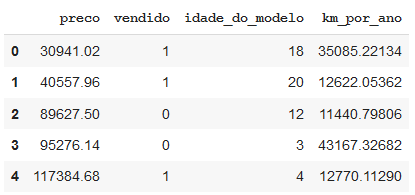

Mas podemos gerar uma coluna nova de dados para podemos explorarmos.

Vamos criar uma coluna que represente o modelo do carro e, acredito que o modelo esteja muito ligado à idade do modelo do carro (que temos no dataset).

Então, vou usar idade_do_modelo para me basear no modelo.

Até poderia usar essa informação como sendo o modelo, mas seria um tanto 'fake', pois todos os carros criados 20 anos atrás são do mesmo modelo, de 19 anos atrás, são do mesmo modelo. Eu teria tantos modelos quantos fosses as idades.

Em vez disso, vamos colocar alguma aleatoriedade aí. Exemplo: se o carro foi criado 18 anos atrás, talvez esse carro seja de um modelo A, B ou C. Um que for no ano 18, 17 e 19 (um pouco atrás ou pra frente). 



In [24]:
np.random.seed(SEED)
#Criando uma coluna com a idade do modelo com + ou - 2 para cada um dos carros.
dados['modelo_aleatorio'] = dados.idade_do_modelo + np.random.randint(-2, 3, len(dados)) #gera número aleatórios inteiros entre -2 e 2, do tamanho do dataframe dos carros.

In [25]:
#Visualizando os 5 primeiros elementos
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo_aleatorio
0,30941.02,1,18,35085.22134,16
1,40557.96,1,20,12622.05362,22
2,89627.50,0,12,11440.79806,12
3,95276.14,0,3,43167.32682,4
4,117384.68,1,4,12770.11290,3


Então agora, já tenho um pouco de aleatoriedade, de acordo com a idade do modelo. Será o suficiente para trabalharmos com os modelos dos carros.

Vamos ver os modelos gerados:

In [26]:
dados.modelo_aleatorio.unique()

array([16, 22, 12,  4,  3, 11, 18, 17, 13,  0, 15, 10,  9, 14,  1,  5, 19,
       21,  8,  7, 20,  6,  2, -1])

Veja que gerou um modelo meio bizarro: -1.

Quero tirá-lo daí e, uma das maneiras é: pegar o menor desse valores do array e somar 1 a ele, de modo que ele passará a ser 0. (Se ele fosse -10, eu somaria 10).

Então, o que posso fazer é pegar o valor absoluto desse número mínimo e somar em toda a coluna. Então, a coluna modelo_aleatório agora será o valor da coluna + o valor absoluto mínimo, de modo que o valor mínimo do array representando os modelos dos carros será 0.

In [27]:
dados.modelo_aleatorio = dados.modelo_aleatorio + abs(dados.modelo_aleatorio.min())
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo_aleatorio
0,30941.02,1,18,35085.22134,17
1,40557.96,1,20,12622.05362,23
2,89627.50,0,12,11440.79806,13
3,95276.14,0,3,43167.32682,5
4,117384.68,1,4,12770.11290,4


Verificando que o valor mínimo do modelo_aleatorio é zero:

In [28]:
dados.modelo_aleatorio.min()

0

Pessoalmente, acho estranho haver um modelo como 0. Então, somemos + 1 para que o modelo inicial seja 1:

In [29]:
dados.modelo_aleatorio = dados.modelo_aleatorio + abs(dados.modelo_aleatorio.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo_aleatorio
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [30]:
dados.modelo_aleatorio.min()

1

In [31]:
dados.modelo_aleatorio.unique()

array([18, 24, 14,  6,  5, 13, 20, 19, 15,  2, 17, 12, 11, 16,  3,  7, 21,
       23, 10,  9, 22,  8,  4,  1])

Veja que os modelos aleatórios não tem exatamente todos os números de 1 a 24.

Vamos mudar o nome do campo para simplesmente 'modelo':

In [32]:
dados.rename(columns={'modelo_aleatorio': 'modelo'}, inplace = True)

Contando o número de carros por modelo:

In [33]:
dados.modelo.value_counts()

20    901
19    798
18    771
21    723
17    709
16    668
14    621
22    575
15    573
13    557
12    511
11    401
10    371
23    370
9     336
8     278
7     206
24    199
6     181
5     108
4      76
3      44
2      17
1       6
Name: modelo, dtype: int64

In [34]:
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


O próximo passo será rodar o classificador.

##Validação cruzada usando grupos

Agora que temos os dados com o modelo do veículo, quero testar o estimador/algoritmo.

Lembre: para testar o estimador, é super importante fazer uma escolha sobre o tipo de treino e teste, pois se usarmos um tipo de treino/teste errado, terei uma estimativa que não é realista com o quão bem o estimador vai rodar no mundo real.

Exemplo: Se usarmos o StratifiedKFold, ele ignorará os grupos (agrupamentos) dos modelos. E se ignorarmos, o estimador se sairá muito bem. 

Mas lembra: isso ocorrerá pois todos os modelos de carro aparecerão tanto no treino quanto no teste, o que não é realista. No mundo real, daqui a pouco terei um modelo de carro novo e o algoritmo precisa saber se virar com esse novo modelo.

Então, não posso usar o StratifieKFold. O mesmo para o KFold: Não poderíamos usar pois também estaria usando todos os modelos de carro para prever todos os modelos, o que não queremos.

Assim, **para ser realista, queremos ser capazes de, na validação cruzada, separar treino e teste de acordo com os grupos.**

No sklearn há **validação cruzada que separa por grupo, a GroupKFold**:

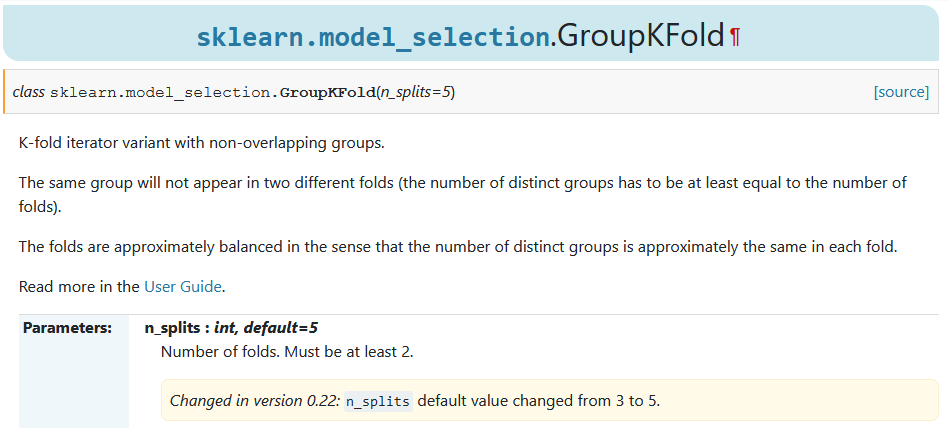

Vamos então utilizar o GroupKFold na avaliação do estimador. 

E atenção: precisamos informar ao cross_validate qual é o grupo, ou seja, qual coluna possui os grupos. Esse é um dos parâmetros do cross_validate, não do GroupKFold:

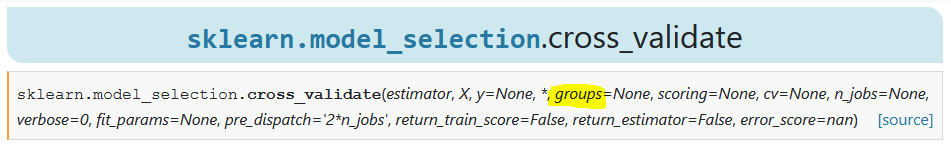

In [35]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

#Definindo o n_splits como 10. Note que não tem mais shuffle.
cv = GroupKFold(n_splits = 10) 
modelo = DecisionTreeClassifier(max_depth=2)
#Precisamos informar os dados da coluna dos grupos
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo) #Usando o cv generator
imprime_resultados(results)

Accuracy médio 75.78
Accuracy intervalo = [73.67, 77.90]


Veja que o resultado ficou bem próximo do cross_validate com StratifiedKFold. A média deu a mesma e o intervalo bem próximo.

Claro que poderia dar diferente! Estão próximos porque os dados de um modelo de carro estão funcionando de uma maneira muito parecida com outros modelos de carro. Mas isso não precisava necessariamente ser verdade. 

De repente aparece aqui um carro voador, que vai pro espaço, e a maneira de precificá-lo é totalmente diferente do que esse estimador é capaz de classificar. E aí o resultado aqui não seria tão bom assim.

Como aqui, os carros em geral se comportam de modo indiferente de acordo com o modelo, então nossa classificação foi muito próxima, levando em consideração ou não o modelo do carro. (Levando em consideração não para estimar, mas para treinar e testar).

Repare que o nosso x_azar continua sendo sem a informação do modelo, ou seja, para classificar só utilizamos 'preco', 'idade_do_modelo' e 'km_por_ano'.








In [36]:
x_azar

,preco,idade_do_modelo,km_por_ano
4999,74023.29,12,24812.80412
5322,84843.49,13,23095.63834
5319,83100.27,19,36240.72746
5316,87932.13,16,32249.56426
5315,77937.01,15,28414.50704
...,...,...,...
5491,71910.43,9,25778.40812
1873,30456.53,6,15468.97608
1874,69342.41,11,16909.33538
5499,70520.39,16,19622.68262


OBS.: O x_azar foi extraído após a ordenação do dataframe, onde foi criado o dados_azar. Embora pareça entranho usar o x_azar (de dados_azar) junto com o dados.modelo, não há problema, pois os índices do DataFrame vão se manter. Esclarecido neste post:

https://cursos.alura.com.br/forum/topico-o-exemplo-de-validacao-cruzada-usando-groupkfold-esta-correto-120322

Ainda que tenha havido essa resposta, eu Thiago acho que está errado, até porque os resultados da taxa de acerto (acurácia) são diferentes. Ou seja: usaria o mesmo dataframe para X, y e groups.

Veremos agora outras maneiras de usarmos a seleção de modelos.

#5. Pipeline de treino e validação

O que será visto:

- Treinar usando o módulo SVC

- O que é pipeline

- Utilizar o pipeline

Agora queremos dar uma olhada em outro tipo de estimador com validação cruzada.

Para a árvore de decisão, como visto no passado, não precisamos balancear / escalar nossas features. Alguns algoritmos, como o SVM precisa, pois são muito sensíveis à escala das features. Ex.: Feature A varia de  0 a 20 e Feature B varia de 0 a 90.000, esta última terá uma influência muito forte no algoritmo. Nesses casos, nós reescalamos as features nos algoritmos sensíveis à escala/grandeza dos dados.

Vamos então rodar o estimador SVC (classificador).

**Cross validation com StandardScaler**

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

#Setando o SEED por conta da aleatoriedade
#OBS = O Scaler não usa o SEED
SEED = 301
np.random.seed(SEED)

#Escalando o dados
scaler = StandardScaler()
scaler.fit(treino_x)
treino_x_escalado = scaler.transform(treino_x)
teste_x_escalado = scaler.transform(teste_x)

#Treinando o Modelo SVC
modelo = SVC()
modelo.fit(treino_x_escalado, treino_y)
previsoes = modelo.predict(teste_x_escalado)

#Colhendo os resultados
acuracia = accuracy_score(teste_y, previsoes) * 100
print("A acurácia foi %.2f%%" % acuracia)

A acurácia foi 77.48%


Acurácia de 77,48%.

Agora, queremos rodar a validação cruzada, e não o train_test_split.

Vamos então o cross_validate com agrupamento.

In [41]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

#Definindo o n_splits como 10. Note que não tem mais shuffle.
cv = GroupKFold(n_splits = 10) 
modelo = SVC()
#Precisamos informar os dados da coluna dos grupos
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo) #Usando o cv generator
imprime_resultados(results)

Accuracy médio 77.27
Accuracy intervalo = [74.35, 80.20]


Mas note que rodamos o SVC sem os dados escalados. Usou o x_azar e y_azar, que são os dados crus.

Eu poderia até pensar em pegar o x_azar e fazer o scaler dele: 

In [42]:
#Escalando o x_azar
scaler = StandardScaler()
scaler.fit(x_azar)
x_azar_escalado = scaler.transform(x_azar)

E depois rodar o modelo com o x_azar_escalado:

In [43]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

#Definindo o n_splits como 10. Note que não tem mais shuffle.
cv = GroupKFold(n_splits = 10) 
modelo = SVC()
#Precisamos informar os dados da coluna dos grupos
results = cross_validate(modelo, x_azar_escalado, y_azar, cv = cv, groups = dados.modelo) #Usando o cv generator
imprime_resultados(results)

Accuracy médio 76.70
Accuracy intervalo = [74.30, 79.10]


O resultado foi próximo, ligeiramente pior.

**Mas há problema: o fit do Scaler é feito apenas nos dados de treino.** E ao fazer no x_azar, estou fazendo fit em tudo: no treino e no teste. Até porque faremos 10 separações baseadas nos grupos (GroupKFolds), para treinar e testar.

Então, não faremos o fit do Scaler uma única vez, mas diversas vezes, ou seja: 1 vez o fit do Scaler com 1 conjunto de dados, depois a validação desse conjunto. Pega o outro grupo e faz o mesmo processo: Scaler => Validação... e assim vai até repetir o processo com os k grupos. Rodamos o fit do Scaler com a parte de treino e rodamos a validação com os dados de teste.

Portanto, temos um processo de 2 fases:

1º: Pré-processamento. Scaler nos dados

2º: Validação.

E esse processo precisa ser rodado várias vezes, de acordo com os nossos grupos (folds / splits).

Vamos criar um processo no sklear, o que se chama de pipeline.

In [44]:
from sklearn.pipeline import Pipeline

scaler = StandardScaler() #transformação
modelo = SVC() #estimador

#Poderia criar o pipeline conf. abaixo:
#pipeline = Pipeline(scaler, modelo)

#Mas há um modo mais elegante, passando num array com o nome da etapa, o que facilitará a visualização depois as fases
pipeline = Pipeline([('transformacao', scaler), ('estimador', modelo)])
pipeline

Pipeline(steps=[('transformacao', StandardScaler()), ('estimador', SVC())])

E o pipeline funciona como um estimador: Possui os métodos fit, predict, como se fosse um estimador. Então, podemos passá-lo para um processo de cross_validate:

In [45]:
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler() #transformação
modelo = SVC() #estimador

#Poderia criar o pipeline conf. abaixo:
#pipeline = Pipeline(scaler, modelo)
#Mas há um modo mais elegante, passando num array com o nome da etapa, o que facilitará a visualização depois as fases
pipeline = Pipeline([('transformacao', scaler), ('estimador', modelo)])

#Definindo o n_splits como 10. Note que não tem mais shuffle.
cv = GroupKFold(n_splits = 10) 
modelo = SVC()
#Precisamos informar os dados da coluna dos grupos
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo) #Usando o cv generator
imprime_resultados(results)

Accuracy médio 76.68
Accuracy intervalo = [74.28, 79.08]


Para cada um dos grupos/splits, o pipeline rodou tanto a transformação (scaler) quanto o estimador (SVC).

**Então, fica a lição: Para rodar a validação cruzada em algoritmos que tenham pré-processamento, e queira fazer o treino (fit) do pré-processamento só nos dados de treino, então precisará colocar dentro de um pipeline.**

##Treinando o modelo final

Agora que temos diversas abordagens de validação você vai escolher a que acredita ser ideal para as características dos seus dados, do seu dataset, de acordo com o que deseja predizer.

A média e o intervalo providos pela validação cruzada diz o quão bem você espera que o modelo se comporte com dados previamente desconhecidos mas... se você usou cross validation com 10 folds, qual dos 10 modelos treinados você vai usar agora no mundo real?

**A ideia é que a validação cruzada num conjunto de dados somente te diz o que você pode esperar. Ela não treina o seu modelo final.**

Agora você tem o algoritmo do estimador (por exemplo um DecisionTreeClassifier) e pretende usá-lo no mundo real:

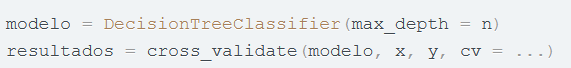

**Resultados indica o que esperar**. **Para obter o modelo final basta treiná-lo em todos os dados que você usou para o crossvalidation:**

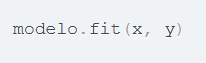

**Pronto, seu modelo está pronto para ser usado com o predict para classificar etc dados novos.**

Referência adicional: How to train the final model after cross-validation?

https://stats.stackexchange.com/questions/331250/how-to-train-the-final-model-after-cross-validation


#Conclusão

Começamos carregando os dados que representam possíveis vendas de veículos no site. Esses dados foram gerados para podermos trabalhar com algorítimos de classificação. Primeiro, utilizamos um algorítimo baseado em DummyClassifier e ele estava abaixo do ideal, com 51%. Então usamos um DecisionTreeClassifier para medir quão bem ela se sairia, e o resultado foi 71.92%. Mas, percebemos que este número, uma vez que utilizávamos o algorítimo de Holdout — separando elementos para treino e para teste — ficava muito suscetível à escolha dos elementos. Se escolhêssemos uma única vez determinados elementos, essa taxa poderia ser 30% ou 70%. No cenário que trabalhamos obtivemos 71% ou 76%. Há uma razoável diferença entre esses dois números, mas poderia ser pior.

Por essa razão, em vez de usarmos um simples DecisionTreeClassifier, nós decidimos rodar várias vezes. Assim, tiramos um pouco da suscetibilidade, e passamos a ter mais informações sobre a capacidade de estimar casos, como se um carro será ou não vendido, para informações por ele ainda não vistas. Isso foi feito separando os dados em K partes. Fizemos a validação cruzada do nosso algorítimo com esses dados 3 vezes, tiramos a média e o intervalo com desvio padrão. Esse foi o número que passamos a medir em distintas situações, utilizando validação cruzada com 10 e 5 Folds.

Depois, vimos a importância da aleatoriedade e distribuição desses dados, mesmo com nossos Folds. Também tratamos de situações de azar, entendendo a importância do split com o shuffle e do StratifiedKFold. Em seguida, aprendemos sobre gerar um tipo de dado específico, que faria com que cada uma das nossas linhas de dados — que antes eram independentes — tenham uma dependência que as deixa em conjunto. Ou seja, nossas leituras deixaram de ser independentes entre si, porque há um modelo de carros que os agrupa.

A partir disso, queríamos saber se nosso estimador conseguiria funcionar bem para modelos de carros novos, ou seja, desconhecidos. Para podermos estimar isso, devemos ser capazes de treinar só com um conjunto de grupo — os modelos — e testar em um grupo totalmente novo, que nunca tinha sido visto anteriormente. Como usamos dados criados por nós, criamos outro dado novo — modelo — e usamos diversos desses modelos de carros para cada um dos nossos veículos. Com GroupKFold, foi feita a validação cruzada, levando em consideração os grupos.

Por fim, demos uma passada na validação cruzada com o StandardScaler, quando temos uma fase de pré processamento que vai alterar alguma informação importante, porque o nosso algorítimo de treino dependerá do StandardScaler. Porém, isto deve ser rodado N vezes para cada um dos treino e teste que tínhamos dentro da validação cruzada. Por isso, tivemos que colocar o processo do StandardScaler e do SVC() para essas validações serem rodadas.

Isto feito, o cross_validate com um processo, o Pipeline, constituído por dois passos: transformação e estimador.

Aqui, abordamos diversas alternativas para validação cruzada. Assim, vocês têm conhecimento para escolher a melhor opção para seus projetos. Se o que você quer responder é como o algorítimo funciona para dados como esses, é uma coisa. Agora se tem um grupo que você quer saber como se comporta para grupos novos, é outro tipo de validação que será utilizada e é bom levar tudo isso em consideração na medida em que rodamos os algorítimos.